# Deep Convolutional Generative Adversarial Networks (DCGAN)

## MNIST

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def normalize_images(images):
  return images / 255.

In [3]:
def make_discriminator_model(input_shape=(28, 28, 1)):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', 
                                   input_shape=input_shape))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(tf.keras.layers.Dropout(0.4))

  model.add(tf.keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(tf.keras.layers.Dropout(0.4))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [4]:
make_discriminator_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

In [5]:
def make_generator_model(latent_dim=100):
  model = tf.keras.Sequential()
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  model.add(tf.keras.layers.Dense(n_nodes, input_dim=latent_dim))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(tf.keras.layers.Reshape((7, 7, 128)))
  # upsample to 14x14
  model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), 
                                            padding='same'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  # upsample to 28x28
  model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), 
                                            padding='same'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(tf.keras.layers.Conv2D(1, (7,7), activation='sigmoid', 
                                   padding='same'))
  return model

In [6]:
make_generator_model().summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                            

In [7]:
def make_gan_model(g_model, d_model):
  d_model.trainable = False

  model = tf.keras.Sequential()
  model.add(g_model)
  model.add(d_model)

  opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [8]:
make_gan_model(make_generator_model(), make_discriminator_model()).summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 40705     
                                                                 
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


In [9]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

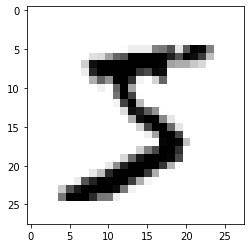

Shape: (28, 28)


In [10]:
plt.imshow(train_images[0],  cmap='gray_r')
plt.show()
print("Shape: {}".format(train_images[0].shape))

In [11]:
dataset = train_images.astype('float32')
dataset = dataset / 255.0

dataset = tf.expand_dims(dataset, -1).numpy()

In [12]:
def get_real_samples(dataset, batch_size):
  indx = tf.random.uniform((batch_size,), 
                           maxval=dataset.shape[0], dtype=tf.int32).numpy()
  X = dataset[indx]
  y = tf.ones((batch_size, 1))
  return X, y

In [13]:
def get_fake_samples(g_model, latent_dim, batch_size):
  samples = tf.random.normal((batch_size, latent_dim))
  X = g_model.predict(samples)
  y = tf.zeros((batch_size, 1))
  return X, y

In [14]:
def plot_images(images):
  fig = plt.figure()
  for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray_r')
    plt.axis('off')
  plt.show()

In [15]:
def train(gan_model, g_model, d_model, dataset,
          latent_dim, batch_size=256, n_epochs=100):
  
  n_batches = dataset.shape[0] // batch_size
  half_batch_size = batch_size // 2
  for i in range(n_epochs):
    for j in range(n_batches):
      X_real, y_real = get_real_samples(dataset, half_batch_size)
      X_fake, y_fake = get_fake_samples(g_model, latent_dim, half_batch_size)
      X, y = tf.concat((X_real, X_fake), axis=0), tf.concat((y_real, y_fake), 
                                                            axis=0)
      d_loss = d_model.train_on_batch(X, y)

      X_gan = tf.random.normal((batch_size, latent_dim))
      y_gan = tf.ones((batch_size, 1))

      gan_loss = gan_model.train_on_batch(X_gan, y_gan)

    if (i+1)%10 == 0:
      plot_images(X_fake)
      print(d_loss, gan_loss)

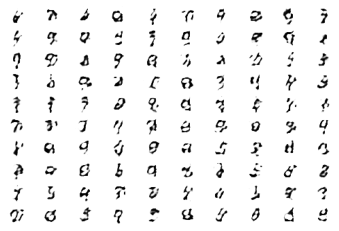

0.6848309636116028 0.7098214626312256


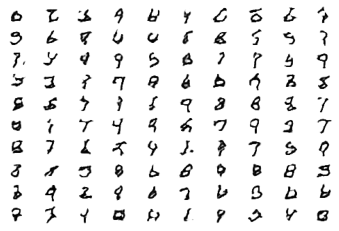

0.6887856721878052 0.7399784326553345


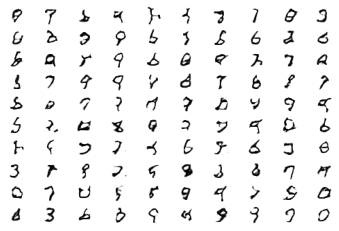

0.6888741850852966 0.709231972694397


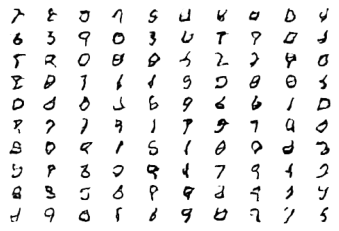

0.6946642398834229 0.7075914144515991


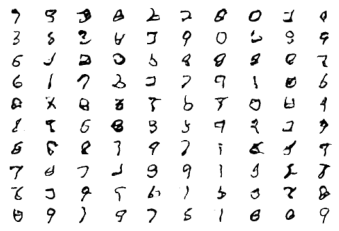

0.6982115507125854 0.7042693495750427


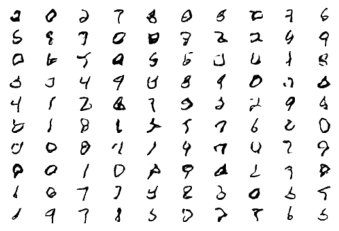

0.6941812038421631 0.7189068794250488


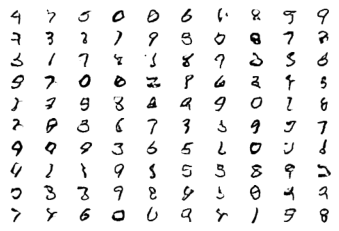

0.6894813179969788 0.7206349968910217


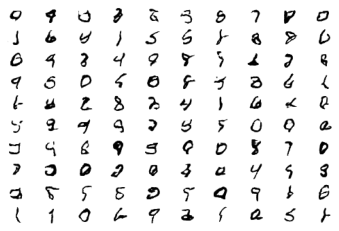

0.6882823705673218 0.7315846085548401


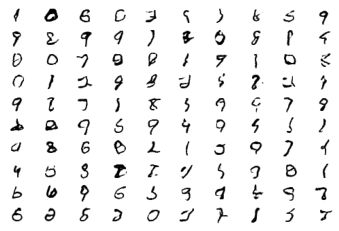

0.696970522403717 0.6932398080825806


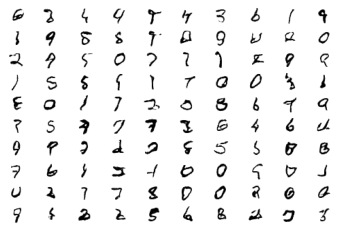

0.6930753588676453 0.6986880898475647


In [16]:
d_model = make_discriminator_model()
g_model = make_generator_model(100)
gan_model = make_gan_model(g_model, d_model)


train(gan_model, g_model, d_model, dataset, 100)

## CIFAR-10

In [85]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [86]:
def normalize_images(images):
  X = (images - 127.5) / 127.5
  return X

In [87]:
def make_discriminator_model(input_shape=(32, 32, 3)):
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', 
                                   input_shape=input_shape))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

  model.add(tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

  model.add(tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

  model.add(tf.keras.layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [88]:
make_discriminator_model().summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_91 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_141 (LeakyReLU)  (None, 32, 32, 64)       0         
                                                                 
 conv2d_92 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_142 (LeakyReLU)  (None, 16, 16, 128)      0         
                                                                 
 conv2d_93 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_143 (LeakyReLU)  (None, 8, 8, 128)        0         
                                                                 
 conv2d_94 (Conv2D)          (None, 4, 4, 256)       

In [89]:
def make_generator_model(latent_dim=100):
  model = tf.keras.Sequential()

  n_nodes = 256 * 4 * 4
  model.add(tf.keras.layers.Dense(n_nodes, input_dim=latent_dim))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(tf.keras.layers.Reshape((4, 4, 256)))

  model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), 
                                            padding='same'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

  model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), 
                                            padding='same'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

  model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), 
                                            padding='same'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

  model.add(tf.keras.layers.Conv2D(3, (3,3), activation='tanh', 
                                   padding='same'))
  return model

In [90]:
make_generator_model().summary()

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 4096)              413696    
                                                                 
 leaky_re_lu_145 (LeakyReLU)  (None, 4096)             0         
                                                                 
 reshape_19 (Reshape)        (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_50 (Conv2D  (None, 8, 8, 128)        524416    
 Transpose)                                                      
                                                                 
 leaky_re_lu_146 (LeakyReLU)  (None, 8, 8, 128)        0         
                                                                 
 conv2d_transpose_51 (Conv2D  (None, 16, 16, 128)      262272    
 Transpose)                                          

In [91]:
def make_gan_model(g_model, d_model):
  d_model.trainable = False

  model = tf.keras.Sequential()
  model.add(g_model)
  model.add(d_model)

  opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [92]:
make_gan_model(make_generator_model(), make_discriminator_model()).summary()

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_57 (Sequential)  (None, 32, 32, 3)         1466115   
                                                                 
 sequential_58 (Sequential)  (None, 1)                 522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


In [93]:
from keras.datasets import cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

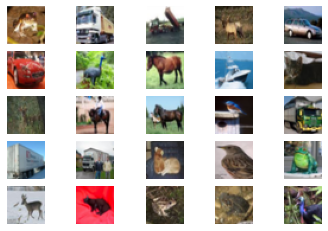

Shape: (32, 32, 3)


In [94]:
for i in range(25):
  plt.subplot(5, 5, 1+i)
  plt.axis('off')
  # plot raw pixel data
  plt.imshow(train_images[i])
plt.show()
print("Shape: {}".format(train_images[0].shape))

In [95]:
dataset = train_images.astype('float32')
dataset = normalize_images(dataset)

In [96]:
def get_real_samples(dataset, batch_size):
  indx = tf.random.uniform((batch_size,), 
                           maxval=dataset.shape[0], dtype=tf.int32).numpy()
  X = dataset[indx]
  y = tf.ones((batch_size, 1))
  return X, y

In [97]:
def get_fake_samples(g_model, latent_dim, batch_size):
  samples = tf.random.normal((batch_size, latent_dim))
  X = g_model.predict(samples)
  y = tf.zeros((batch_size, 1))
  return X, y

In [98]:
def plot_images(images):
  images = (images + 1) / 2.0
  fig = plt.figure()
  for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
  plt.show()

In [101]:
def train(gan_model, g_model, d_model, dataset,
          latent_dim, batch_size=128, n_epochs=100):
  
  n_batches = dataset.shape[0] // batch_size
  half_batch_size = batch_size // 2
  for i in range(n_epochs):
    for j in range(n_batches):
      X_real, y_real = get_real_samples(dataset, half_batch_size)
      X_fake, y_fake = get_fake_samples(g_model, latent_dim, half_batch_size)
      X, y = tf.concat((X_real, X_fake), axis=0), tf.concat((y_real, y_fake), 
                                                            axis=0)
      d_loss = d_model.train_on_batch(X, y)

      X_gan = tf.random.normal((batch_size, latent_dim))
      y_gan = tf.ones((batch_size, 1))

      gan_loss = gan_model.train_on_batch(X_gan, y_gan)

    if (i+1)%10 == 0:
      plot_images(X_fake)
      print(d_loss, gan_loss)

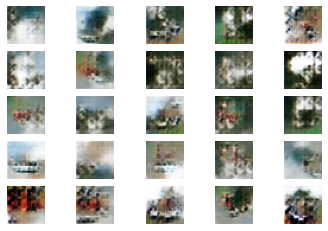

0.601250946521759 1.1775753498077393


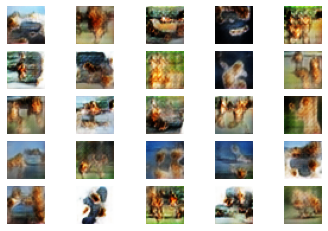

0.5907909274101257 0.8446939587593079


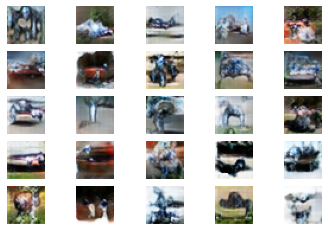

0.6280171871185303 0.8150941729545593


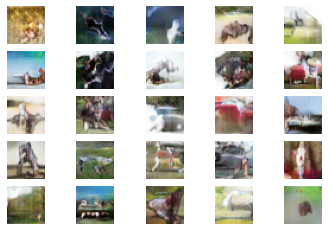

0.6240725517272949 0.7737029194831848


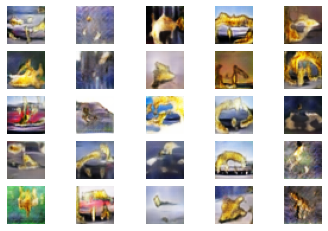

0.6642067432403564 0.8125234842300415


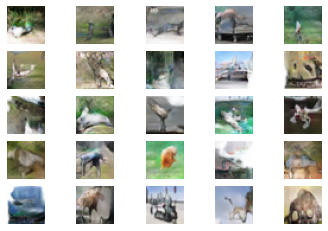

0.6011841297149658 0.7584607601165771


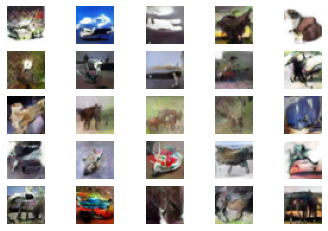

0.6771332621574402 1.1028305292129517


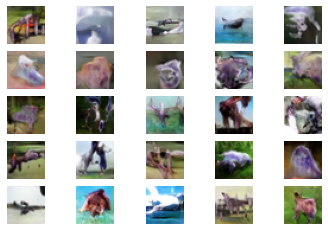

0.6544252038002014 0.8120908737182617


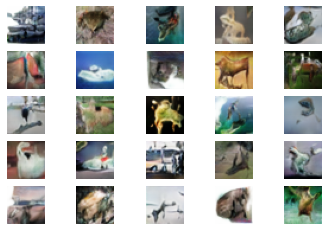

0.5810636878013611 0.8896050453186035


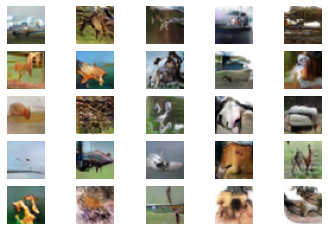

0.6040589809417725 0.9204650521278381


In [102]:
d_model = make_discriminator_model()
g_model = make_generator_model(100)
gan_model = make_gan_model(g_model, d_model)

train(gan_model, g_model, d_model, dataset, 100)